## Probit model
---


In [1]:
%matplotlib inline
import numpy as np
import scipy.stats as st
import pandas as pd
import matplotlib.pyplot as plt
import pymc3 as pm
from IPython.display import display
# workaround for Theano compilation errors
import theano
theano.config.gcc.cxxflags = '-Wno-c++11-narrowing'

Because the cumulative probability function of the normal distribution is not available, we define it here.

In [2]:
def normal_cdf(x):
    return 0.5 * (1.0 + pm.math.erf(x / pm.math.sqrt(2.0)))

The following cell generates data from 

$$
 y_i = \begin{cases}
 1, & \text{with probability}\quad \mu_i; \\
 0, & \text{with probability}\quad 1-\mu_i.
 \end{cases}
$$

$$
 \Phi^{-1}(\mu_i) = 0.5 x_{1i} - 0.5 x_{2i},\quad i=1,\dots,500.
$$

In [3]:
n = 500
np.random.seed(99)
x1 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
x2 = st.uniform.rvs(loc=-np.sqrt(3.0), scale=2.0*np.sqrt(3.0), size=n)
q = st.norm.cdf(0.5*x1 - 0.5*x2)
y = st.bernoulli.rvs(q)
X = np.stack((np.ones(n), x1, x2), axis=1)

In [4]:
n, k = X.shape
b0 = np.zeros(k)
A0 = 0.01 * np.eye(k)
probit_model = pm.Model()
with probit_model:
    b = pm.MvNormal('b', mu=b0, tau=A0, shape=k)
    idx = pm.math.dot(X, b)
    likelihood = pm.Bernoulli('y', p=normal_cdf(idx), observed=y)
n_draws = 5000
n_chains = 4
n_tune = 1000
with probit_model:
    trace = pm.sample(draws=n_draws, chains=n_chains, tune=n_tune, random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
ERROR (theano.gof.opt): Optimization failure due to: local_grad_log_erfc_neg
ERROR (theano.gof.opt): node: Elemwise{true_div,no_inplace}(Elemwise{mul,no_inplace}.0, Elemwise{erfc,no_inplace}.0)
ERROR (theano.gof.opt): TRACEBACK:
ERROR (theano.gof.opt): Traceback (most recent call last):
  File "/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/theano/gof/opt.py", line 2034, in process_node
    replacements = lopt.transform(node)
  File "/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/theano/tensor/opt.py", line 6789, in local_grad_log_erfc_neg
    if not exp.owner.inputs[0].owner:
AttributeError: 'NoneType' object has no attribute 'owner'

Multiprocess sampling (4 chains in 4 jobs)
NUTS: [b]
Sampling 4 chains, 0 divergences: 100%|██████████| 24000/24000 [00:08<00:00, 2879.60draws/s]


In [5]:
display(pm.summary(trace))

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
b[0],-0.056,0.061,-0.171,0.057,0.0,0.0,28231.0,15651.0,28194.0,13941.0,1.0
b[1],0.437,0.063,0.320,0.556,0.0,0.0,22431.0,22119.0,22430.0,14007.0,1.0
b[2],-0.468,0.064,-0.589,-0.351,0.0,0.0,27514.0,26462.0,27501.0,15450.0,1.0


/Users/teruo/.pyenv/versions/miniconda3-latest/envs/bayes/lib/python3.7/site-packages/arviz/plots/backends/matplotlib/distplot.py:38: UserWarning: Argument backend_kwargs has not effect in matplotlib.plot_distSupplied value won't be used
  "Argument backend_kwargs has not effect in matplotlib.plot_dist"


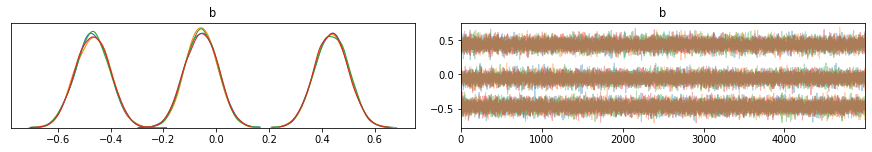

In [6]:
pm.traceplot(trace)
plt.show()

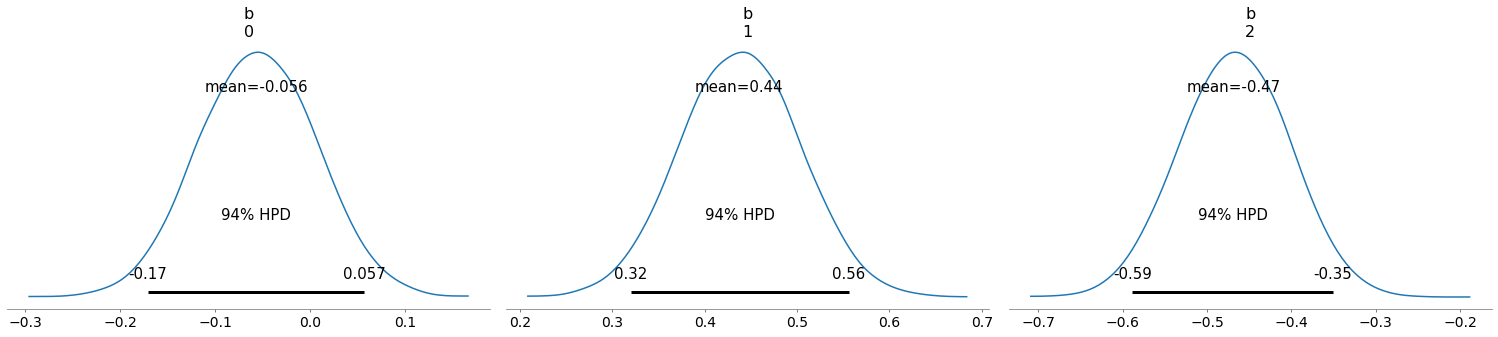

In [7]:
pm.plot_posterior(trace, kind='kde', point_estimate='mean')
plt.show()